<h1>Research Papers analytics using term frequency/document frequency</h1>
<p>In this notebook, we will explore the dataset obtain from crawling research papers</p>

In [1]:
# -*- coding: utf-8 -*-
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import timeit
import codecs
import re
import os
from bs4 import BeautifulSoup # $ pip install beautifulsoup4
from wordcloud import WordCloud
%matplotlib inline

In [2]:
cleaned_papers_pdf = pd.read_csv('../dataset/cleaned_papers_pdf.csv',encoding='utf-8')
print("%d papers with %d different faculty were loaded"%(cleaned_papers_pdf.shape[0],cleaned_papers_pdf['faculty'].unique().shape[0]))

1042 papers with 4 different faculty were loaded


In [3]:
cleaned_papers_pdf['faculty'].value_counts()

ICT_professor    576
MSME             192
MT               188
BIO               86
Name: faculty, dtype: int64

In [4]:
paper = pd.DataFrame({})
for faculty in cleaned_papers_pdf['faculty'].unique():    
    paper = pd.concat([paper,cleaned_papers_pdf[cleaned_papers_pdf['faculty']==faculty].sample(80)])

In [5]:
name_list = []
for name in cleaned_papers_pdf['name']:
    name_list.extend(name.lower().split(" "))

In [6]:
#Content2Words (or String to words seperate by space)
from nltk.corpus import stopwords # Import the stop word list
from nltk.stem import WordNetLemmatizer

def content_to_words( paper_content ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", paper_content) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))      
    paper_stop = ['cid','fig','however','respectively','used','therefore','pp','figure','vol','table','time','let','co','using','set','page','th','etal','ij','daml','green','op','owl','gre','foilmp','suntec','aclandafnlp',
                 'togaf',
'cmmi',
'forexample',
'nn',
'ilp',
'cc',
'edus',
'proc',
'dog',
'er',
'org']
    paper_stop.extend(name_list)
    stops |= set(paper_stop)
    
    
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops] 
    
    # 5. Lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()
    meaningful_words = [wordnet_lemmatizer.lemmatize(w) for w in meaningful_words if len(w)!=1 or w in['a','i','u']]
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   
words = content_to_words('testing to convert and also cleaning. Yeah') 

In [7]:
#Cleaning all of the content csv
start = timeit.default_timer()
cleaned_papers_pdf['cleaned_content'] = cleaned_papers_pdf['content'].apply(content_to_words)
stop = timeit.default_timer()
print("Execution time : "+str(round(stop - start,2))+"s.")    

Execution time : 23.91s.


In [8]:
#Creating Bags of Words
print("Creating the bag of words...\n")
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
tfidf_vectorizer = TfidfVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 10000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
tfidf_train_features = tfidf_vectorizer.fit_transform(cleaned_papers_pdf['cleaned_content'])
print("tf-idf features created")

Creating the bag of words...

tf-idf features created


from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, n_iter=450, random_state=42)
#reduced_X = svd.fit_transform(tfidf_train_features) 

In [12]:
#print(svd.explained_variance_ratio_)

In [13]:
#Set all number of faculty to be equal first

In [14]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=5)

reduced_X = model.fit_transform(tfidf_train_features.toarray()) 

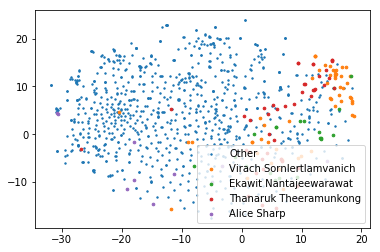

In [15]:
# get the indices where data is 1
def focus_professor(names):
    
    isnOwner = reduced_X[cleaned_papers_pdf['name'].apply(lambda x: x not in names)]
    x,y = isnOwner.T
    plt.scatter(x,y,s=2,label='Other')
    for name in names:
        isOwner = reduced_X[cleaned_papers_pdf['name'].apply(lambda x: name in x)]
        x,y = isOwner.T
        plt.scatter(x,y,s=7,label=name)
    plt.legend()
    plt.show()
focus_professor(['Virach Sornlertlamvanich','Ekawit Nantajeewarawat','Thanaruk Theeramunkong','Alice Sharp'])

<p>Note that the x and y axis has no real meaning. Each dot represent one paper. And we assume that if two dot are near to each others, they tend to be similar.</p>

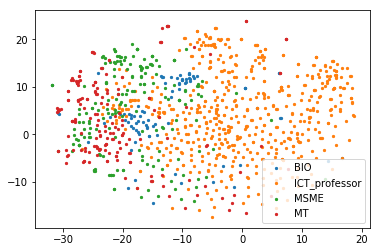

In [16]:
def plot_by_faculty():    
    for faculty in cleaned_papers_pdf['faculty'].unique():
        professors = reduced_X[cleaned_papers_pdf['faculty']==faculty] 
        x,y = professors.T
        plt.scatter(x,y,s=5,label=faculty)
    plt.legend()
    plt.show()
plot_by_faculty()

In [17]:
#Doing Cluster to 10 group.
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=10, random_state=0).fit(tfidf_train_features)

In [18]:
cleaned_papers_pdf['cluster'] = kmeans.labels_

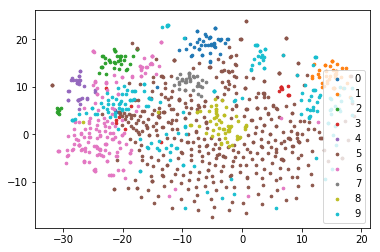

In [19]:
# get the indices where data is 1
def PCA_scatter_plot(seperator='cluster'):
    labels = set(cleaned_papers_pdf[seperator])
    for label in labels:
        isIncluded = reduced_X[cleaned_papers_pdf[seperator].apply(lambda x: x==label)]
        x,y = isIncluded.T
        plt.scatter(x,y,s=7,label=label)
    plt.legend()
    plt.show()
PCA_scatter_plot()

In [20]:
cleaned_papers_pdf['cluster'].value_counts()

5    424
6    174
9    169
8     58
0     48
2     46
1     41
7     32
4     32
3     18
Name: cluster, dtype: int64

In [21]:
freqs = [(word, tfidf_train_features.getcol(idx).sum()) for word, idx in tfidf_vectorizer.vocabulary_.items()]
#sort from largest to smallest
print(sorted(freqs, key = lambda x: -x[1])[0:40])

[('system', 22.354128910736343), ('image', 20.484947688892319), ('model', 18.659956452327272), ('data', 16.173592251765101), ('energy', 15.191827165358424), ('thailand', 15.040213009672811), ('word', 15.038486939402043), ('based', 14.805646368349025), ('cost', 14.617952220496393), ('algorithm', 14.587467167305524), ('result', 14.552530294343732), ('method', 12.908728322058431), ('thai', 12.533680290238394), ('user', 12.402601800549279), ('process', 12.295695832510596), ('number', 12.28124425851604), ('information', 11.948080143445662), ('max', 11.828605418696307), ('management', 11.594089840749881), ('value', 11.560701118588199), ('problem', 11.53716623290172), ('factor', 11.465825367320114), ('phys', 11.371186486674429), ('customer', 11.286432368993861), ('level', 11.192309521074376), ('page', 10.748499518514052), ('example', 10.706023861720873), ('http', 10.620875332691343), ('product', 10.549801205377992), ('one', 10.480348307872028), ('research', 10.363832472589834), ('chem', 10.34

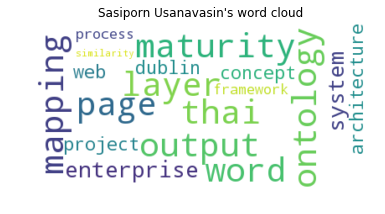

In [48]:
from wordcloud import WordCloud
def professor_wordCloud(name):
    vec_sum = np.array(tfidf_train_features.shape[1]*[0])
    professor_pdf = cleaned_papers_pdf[cleaned_papers_pdf['name']==name]
    rowNum = []
    for i,row in professor_pdf.iterrows():
        vec_sum+=tfidf_train_features.getrow(i)
        rowNum.append(i)
    word_tfidf_vector = vec_sum.tolist()[0]
    sorted_vector_index = sorted(range(len(word_tfidf_vector)), key=lambda k: -word_tfidf_vector[k])
    features_names = tfidf_vectorizer.get_feature_names()
    wordCloudText =''
    j=1000
    for i in sorted_vector_index[0:20]:
        if(len(features_names[i])<15):
            wordCloudText+=((features_names[i])+" ")
    wordcloud = WordCloud(max_font_size=40,background_color="white").generate(wordCloudText)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(name+"'s word cloud")
    plt.show()
    
professor_wordCloud('Sasiporn Usanavasin')

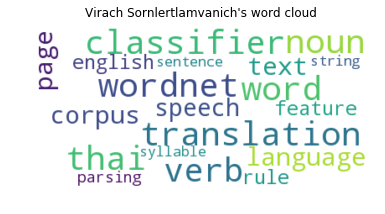

In [49]:
professor_wordCloud('Virach Sornlertlamvanich')

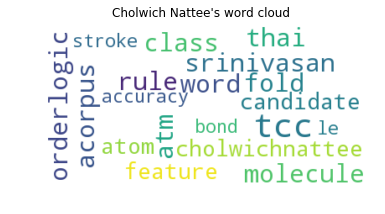

In [24]:
professor_wordCloud('Cholwich Nattee')

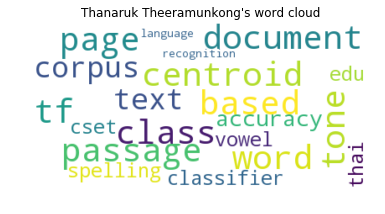

In [25]:
professor_wordCloud('Thanaruk Theeramunkong')

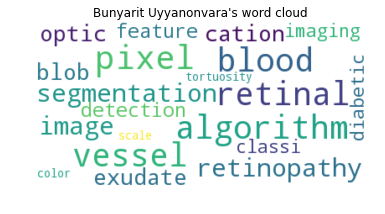

In [26]:
#cleaned_papers_pdf['name'].value_counts()
professor_wordCloud('Bunyarit Uyyanonvara')

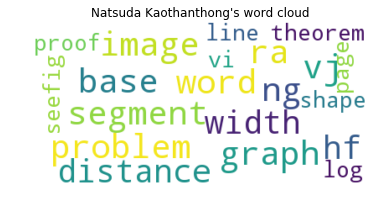

In [27]:
professor_wordCloud('Natsuda Kaothanthong')

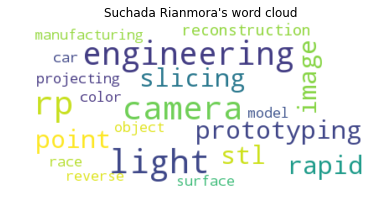

In [28]:
professor_wordCloud('Suchada Rianmora')

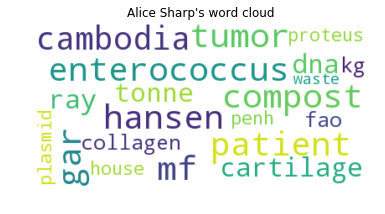

In [29]:
professor_wordCloud('Alice Sharp')

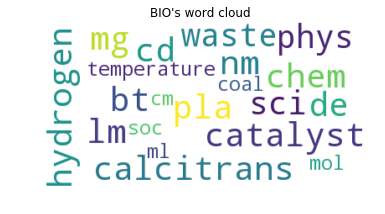

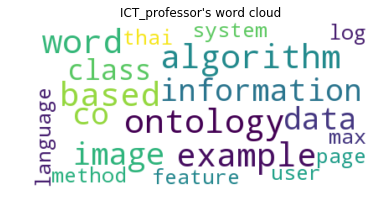

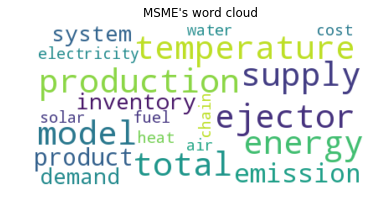

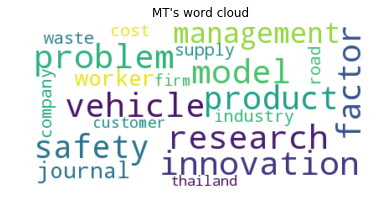

In [30]:
#Word Cloud by faculty
def query_wordCloud(df,title='Table'):
    vec_sum = np.array(tfidf_train_features.shape[1]*[0])
    rowNum = []
    for i,row in df.iterrows():
        vec_sum+=tfidf_train_features.getrow(i)
        rowNum.append(i)
    word_tfidf_vector = vec_sum.tolist()[0]
    sorted_vector_index = sorted(range(len(word_tfidf_vector)), key=lambda k: -word_tfidf_vector[k])
    features_names = tfidf_vectorizer.get_feature_names()
    wordCloudText =''
    j=1000
    for i in sorted_vector_index[0:20]:
        if(len(features_names[i])<15):
            wordCloudText+=features_names[i]+" "
    wordcloud = WordCloud(max_font_size=40,background_color="white").generate(wordCloudText)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title+"'s word cloud")
    plt.show()

for faculty in cleaned_papers_pdf['faculty'].unique():
    query_wordCloud(cleaned_papers_pdf[cleaned_papers_pdf['faculty']==faculty],faculty)

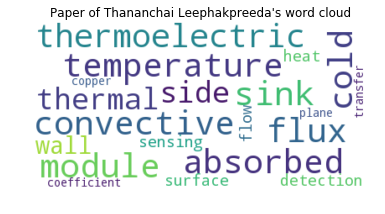

In [54]:
#WordCloud by Paper
sample_paper = cleaned_papers_pdf.sample(1)
query_wordCloud(sample_paper,"Paper of "+sample_paper['name'].values[0])